# Predicting Orange Futures Prices Based on Weather

## CDS Algo Project S21

### Authors: Alex Lin, Brian Bobby, Divya Damodaran, Liam Bodurtha

### TODO for next week (updated 3/27)
- make table of production by county from map (https://www.nass.usda.gov/Statistics_by_State/Florida/Publications/Citrus/Citrus_Statistics/2015-16/fcs1516.pdf)
- Liam and Divya meeting this week to filter/clean data
    - talk about how to replace -99.00 values
    - decide on starting date
    - maybe make one massive dataframe
- Brian and Alex continue to research methodology and come up with concrete options for analysis

In [1]:
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from urllib.request import urlopen, Request
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import yfinance as yf
from datetime import date
import finplot as fplt
import requests
import pandas as pd
import numpy as np
import io
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
from sklearn.model_selection import train_test_split

In [2]:
r1 = requests.get('https://www.quandl.com/api/v3/datasets/CHRIS/ICE_OJ1.csv?api_key=9BZrqXiy4Mck8_br9oG9')
futures_data_1 = pd.read_csv(io.StringIO(r1.text))

r2 = requests.get('https://www.quandl.com/api/v3/datasets/CHRIS/ICE_OJ2.csv?api_key=9BZrqXiy4Mck8_br9oG9')
futures_data_2 = pd.read_csv(io.StringIO(r2.text))

r3 = requests.get('https://www.quandl.com/api/v3/datasets/CHRIS/ICE_OJ3.csv?api_key=9BZrqXiy4Mck8_br9oG9')
futures_data_3 = pd.read_csv(io.StringIO(r3.text))

r4 = requests.get('https://www.quandl.com/api/v3/datasets/CHRIS/ICE_OJ4.csv?api_key=9BZrqXiy4Mck8_br9oG9')
futures_data_4 = pd.read_csv(io.StringIO(r4.text))

r5 = requests.get('https://www.quandl.com/api/v3/datasets/CHRIS/ICE_OJ5.csv?api_key=9BZrqXiy4Mck8_br9oG9')
futures_data_5 = pd.read_csv(io.StringIO(r5.text))

In [3]:
counties = ['Hendry', 'DeSoto', 'Polk', 'Highlands', 'Hardee', 'St Lucie', 'Collier', 'Indian River', 'Manatee', 'Charlotte', 'Lee','Lake', 'Osceola', 'Glades', 'Okeechobee', 'Hillsborough', 'Pasco', 'Martin', 'Orange', 'Brevard', 'Sarasota', 'Marion', 'Volusia', 'Hernando', 'Seminole']
boxes = [14282, 12773, 12539, 9735, 8436, 6693, 6677, 5965, 3282, 2696, 2128, 1606, 1463, 1360, 152, 718, 687, 684, 351, 335, 212, 163, 111, 91, 43]
productionDf = pd.DataFrame({'County:': counties, 'Boxes Produced of Oranges(in 1000s)': boxes })
productionDf

,County:,Boxes Produced of Oranges(in 1000s)
0,Hendry,14282
1,DeSoto,12773
2,Polk,12539
3,Highlands,9735
4,Hardee,8436
5,St Lucie,6693
6,Collier,6677
7,Indian River,5965
8,Manatee,3282
9,Charlotte,2696


In [4]:
futures_data_2.head()

,Date,Open,High,Low,Settle,Change,Wave,Volume,Prev. Day Open Interest,EFP Volume,EFS Volume,Block Volume
0,2021-05-05,109.95,110.75,107.75,108.10,-1.20,NaN,1230.0,11853.0,NaN,NaN,NaN
1,2021-05-04,111.60,112.00,108.50,109.30,-2.30,NaN,1462.0,11464.0,NaN,NaN,NaN
2,2021-05-03,112.05,113.70,111.50,111.60,-0.35,NaN,751.0,11310.0,NaN,NaN,NaN
3,2021-04-30,112.05,112.85,111.75,111.95,-0.10,NaN,727.0,11005.0,NaN,NaN,NaN
4,2021-04-29,113.95,114.30,112.00,112.05,-1.95,NaN,1392.0,10375.0,NaN,NaN,NaN


In [5]:
futures_data_1['Date'] = pd.to_datetime(futures_data_1['Date'])
futures_data_2['Date'] = pd.to_datetime(futures_data_2['Date'])
futures_data_3['Date'] = pd.to_datetime(futures_data_3['Date'])
futures_data_4['Date'] = pd.to_datetime(futures_data_4['Date'])
futures_data_5['Date'] = pd.to_datetime(futures_data_5['Date'])

futures_data_1['Settle_1'] = futures_data_1['Settle']
futures_data_2['Settle_2'] = futures_data_2['Settle']
futures_data_3['Settle_3'] = futures_data_3['Settle']
futures_data_4['Settle_4'] = futures_data_4['Settle']
futures_data_5['Settle_5'] = futures_data_5['Settle']
futures_data_5.head()

,Date,Open,High,Low,Settle,Change,Wave,Volume,Prev. Day Open Interest,EFP Volume,EFS Volume,Block Volume,Settle_5
0,2021-05-05,118.10,118.10,117.75,117.75,-1.30,NaN,8.0,197.0,NaN,NaN,NaN,117.75
1,2021-05-04,120.50,120.50,118.75,119.05,-1.50,NaN,77.0,120.0,NaN,NaN,NaN,119.05
2,2021-05-03,NaN,NaN,NaN,120.55,-0.20,NaN,0.0,120.0,NaN,NaN,NaN,120.55
3,2021-04-30,121.00,121.00,121.00,120.75,-0.25,NaN,4.0,116.0,NaN,NaN,NaN,120.75
4,2021-04-29,121.05,121.05,121.00,121.00,-1.30,NaN,9.0,107.0,NaN,NaN,NaN,121.00


In [6]:
futures_data_5.dtypes

Date                       datetime64[ns]
Open                              float64
High                              float64
Low                               float64
Settle                            float64
Change                            float64
Wave                              float64
Volume                            float64
Prev. Day Open Interest           float64
EFP Volume                        float64
EFS Volume                        float64
Block Volume                      float64
Settle_5                          float64
dtype: object

In [7]:
station_county = pd.read_csv('station_county_matching.csv')

In [8]:
station_county

,Station,County
0,APALACHICOLA AP,Franklin
1,ARCADIA,Desoto
2,ARCHBOLD BIO STN,Highlands
3,AVON PARK 2 W,Highlands
4,BARTOW,Polk
...,...,...
85,VERO BEACH 4SE,Indian River
86,WAUCHULA,Hardee
87,WEEKI WACHEE,Hernando
88,WEST PALM BEACH INTL AP,Palm Beach


In [9]:
weather_station_dfs = {}
for station in station_county['Station']:
    dfname = station.lower().replace(' ','_')
    weather_station_dfs[dfname] = pd.read_csv('orangeCsvs/'+station+'.csv')

In [10]:
weather_station_dfs['arcadia'].head()

,Unnamed: 0,id,year,month,day,precipitation,maxTemp,minTemp,meanTemp
0,0,80228,1899,1,1,-99.99,-99.9,-99.9,-99.90000
1,1,80228,1899,1,2,-99.99,-99.9,-99.9,-99.90000
2,2,80228,1899,1,3,-99.99,-99.9,-99.9,-99.90000
3,3,80228,1899,1,4,-99.99,-99.9,-99.9,-99.90000
4,4,80228,1899,1,5,-99.99,-99.9,-99.9,-99.90000


In [11]:
station_county[station_county['County'] == 'Collier']

,Station,County
37,IMMOKALEE,Collier
58,NAPLES,Collier
60,OASIS RS,Collier


In [12]:
stations_in_citrus_regions = []
for s in range(len(station_county.iloc[:,1].copy())):
    for c in counties:
        if c.lower().replace('saint', 'st') == station_county.iloc[s,1].lower():
              stations_in_citrus_regions.append(station_county.iloc[s,0].lower().replace(' ', '_'))
stations_in_citrus_regions.append('ft_pierce')
 #zero non-null rows - 3 more weather stations available for county 
print(stations_in_citrus_regions)

['arcadia', 'archbold_bio_stn', 'avon_park_2_w', 'bartow', 'bradenton_5_ese', 'brooksville_chin_hill', 'clermont_9_s', 'daytona_beach', 'daytona_beach_intl_ap', 'deland_1_sse', 'desoto_city_8_sw', 'devils_garden', 'fort_drum', 'ft_green_12_wsw', 'ft_myers_page_fld_ap', 'ft_pierce', 'hillsborough_river_sp', 'immokalee', 'kissimmee_2', 'la_belle', 'lisbon', 'melbourne_intl_ap', 'moore_haven_lock_1', 'mtn_lake', 'myakka_river_sp', 'naples', 'oasis_rs', 'ocala', 'okeechobee', 'orlando_intl_ap', 'parrish', 'plant_city', 'punta_gorda_4_ese', 'saint_leo', 'sanford', 'stuart', 'tampa_intl_ap', 'titusville', 'venice', 'vero_beach_intl_ap', 'vero_beach_4se', 'wauchula', 'weeki_wachee', 'ft_pierce']


In [13]:
# fil_weather_station_dfs contains the stations from counties that produce oranges
fil_weather_station_dfs = (weather_station_dfs.fromkeys(stations_in_citrus_regions))

for station in stations_in_citrus_regions:
    fil_weather_station_dfs[station] = weather_station_dfs[station].copy() 

Dropping:
* before start date of futures data (maybe 1967, feb2)
* replace -99.00's with NaN
* ~2 weather stations start at 1978 or later, a few more start between 1967 and 1978, so we should discuss trimming everything to 1978 and 

In [14]:
for dfname in stations_in_citrus_regions:
    fil_weather_station_dfs[dfname] = fil_weather_station_dfs[dfname][fil_weather_station_dfs[dfname]['year'] >= 1967]
    

In [15]:
print(len(fil_weather_station_dfs['oasis_rs']))
fil_weather_station_dfs['oasis_rs'].isnull().sum(axis = 0)

14637


Unnamed: 0       0
id               0
year             0
month            0
day              0
precipitation    0
maxTemp          0
minTemp          0
meanTemp         0
dtype: int64

In [16]:
#Making columns float types and dropping bad column
for station in stations_in_citrus_regions:
    df = fil_weather_station_dfs[station].copy()
    df['precipitation'] = df['precipitation'].astype(float)
    
    df['meanTemp'] = df['meanTemp'].replace(' ','-99.9')
    df['meanTemp'] = df['meanTemp'].astype('float64')
    
    fil_weather_station_dfs[station] = df

In [17]:
fil_weather_station_dfs['arcadia']

,Unnamed: 0,id,year,month,day,precipitation,maxTemp,minTemp,meanTemp
24888,24888,80228,1967,1,1,0.00,81.0,56.0,68.5
24889,24889,80228,1967,1,2,0.00,85.0,65.0,75.0
24890,24890,80228,1967,1,3,0.07,84.0,67.0,75.5
24891,24891,80228,1967,1,4,0.14,77.0,60.0,68.5
24892,24892,80228,1967,1,5,0.00,66.0,32.0,49.0
...,...,...,...,...,...,...,...,...,...
43546,43546,80228,2017,12,27,0.00,79.0,55.0,67.0
43547,43547,80228,2017,12,28,0.00,81.0,56.0,68.5
43548,43548,80228,2017,12,29,0.00,78.0,56.0,67.0
43549,43549,80228,2017,12,30,0.01,-99.9,50.0,-99.9


In [18]:
#replacing -99..9 with Nan
for station in stations_in_citrus_regions:
    fil_weather_station_dfs[station]['meanTemp'] = fil_weather_station_dfs[station]['meanTemp'].replace(-99.9, np.nan)
    
    fil_weather_station_dfs[station]['precipitation'] = fil_weather_station_dfs[station]['precipitation'].replace(-99.9, np.nan)
    
    fil_weather_station_dfs[station]['maxTemp'] = fil_weather_station_dfs[station]['maxTemp'].replace(-99.9, np.nan)
    
    fil_weather_station_dfs[station]['minTemp'] = fil_weather_station_dfs[station]['minTemp'].replace(-99.9, np.nan)


In [19]:
for station in stations_in_citrus_regions:
    fil_weather_station_dfs[station] = fil_weather_station_dfs[station].dropna()

In [20]:
#Dataframes that are only from counties that produce oranges with all year >= 1967 and rows with NaNs dropped
#we still have lots of data
fil_weather_station_dfs['arcadia'].isnull().sum(axis = 0)

Unnamed: 0       0
id               0
year             0
month            0
day              0
precipitation    0
maxTemp          0
minTemp          0
meanTemp         0
dtype: int64

In [21]:
#1970 - immokalee, 2010 - melbourne_intl_ap
for station in fil_weather_station_dfs.keys():
    print(station + ": " + str(len(fil_weather_station_dfs[station]['year'])))

arcadia: 17193
archbold_bio_stn: 17102
avon_park_2_w: 16668
bartow: 17317
bradenton_5_ese: 17267
brooksville_chin_hill: 15779
clermont_9_s: 17461
daytona_beach: 5005
daytona_beach_intl_ap: 17896
deland_1_sse: 16876
desoto_city_8_sw: 0
devils_garden: 15617
fort_drum: 13344
ft_green_12_wsw: 4862
ft_myers_page_fld_ap: 16994
ft_pierce: 17790
hillsborough_river_sp: 54
immokalee: 14594
kissimmee_2: 17107
la_belle: 14027
lisbon: 17552
melbourne_intl_ap: 2008
moore_haven_lock_1: 17760
mtn_lake: 17559
myakka_river_sp: 16715
naples: 17574
oasis_rs: 13227
ocala: 17675
okeechobee: 13338
orlando_intl_ap: 16736
parrish: 16696
plant_city: 17315
punta_gorda_4_ese: 17631
saint_leo: 17697
sanford: 17756
stuart: 16168
tampa_intl_ap: 17897
titusville: 16890
venice: 16311
vero_beach_intl_ap: 11686
vero_beach_4se: 17503
wauchula: 17417
weeki_wachee: 15215


In [22]:
for station in fil_weather_station_dfs.keys():
    if not station == 'desoto_city_8_sw':
        print(station + ": " + str(fil_weather_station_dfs[station]['year'].iloc[0]))

arcadia: 1967
archbold_bio_stn: 1969
avon_park_2_w: 1967
bartow: 1967
bradenton_5_ese: 1967
brooksville_chin_hill: 1967
clermont_9_s: 1967
daytona_beach: 2000
daytona_beach_intl_ap: 1967
deland_1_sse: 1967
devils_garden: 1967
fort_drum: 1967
ft_green_12_wsw: 2001
ft_myers_page_fld_ap: 1967
ft_pierce: 1967
hillsborough_river_sp: 1967
immokalee: 1970
kissimmee_2: 1967
la_belle: 1967
lisbon: 1967
melbourne_intl_ap: 2010
moore_haven_lock_1: 1967
mtn_lake: 1967
myakka_river_sp: 1968
naples: 1967
oasis_rs: 1978
ocala: 1967
okeechobee: 1967
orlando_intl_ap: 1967
parrish: 1967
plant_city: 1967
punta_gorda_4_ese: 1967
saint_leo: 1967
sanford: 1967
stuart: 1967
tampa_intl_ap: 1967
titusville: 1967
venice: 1967
vero_beach_intl_ap: 1984
vero_beach_4se: 1967
wauchula: 1967
weeki_wachee: 1969


In [23]:
#Try merging the station results for each county for each county. If a row is Nan in one station ignore and average witht the other 

In [24]:
station_county['Station'] = station_county['Station'].apply(lambda x: x.lower().replace(' ', '_'))
station_county['County'] = station_county['County'].apply(lambda x: x.lower().replace('saint', 'st'))

county_dfs = {}

for county in counties:
    if county == "St. Lucie":
        county = "St Lucie"
        
    county = county.lower()
    df = pd.DataFrame()
    
    for stat in station_county[station_county['County'] == county]['Station']:
        if stat in fil_weather_station_dfs.keys():
            
            temp_df = fil_weather_station_dfs[stat].copy()
            temp_df['County'] = county
        
            df = df.append(temp_df)
    
    county_dfs[county] = df


In [25]:
productionDf['County:'] = productionDf['County:'].apply(lambda x: x.lower().replace('st.', 'st'))

In [26]:
total_boxes = 0
for coun in county_dfs.keys():
    mult = int(productionDf[productionDf['County:'] == coun]['Boxes Produced of Oranges(in 1000s)'])
    total_boxes += mult
    county_dfs[coun] = (county_dfs[coun].groupby(['year', 'month', 'day']).mean())
    df = county_dfs[coun]
    df['minTemp'] = df['minTemp']*mult
    df['maxTemp'] = df['maxTemp']*mult
    df['meanTemp'] = df['meanTemp']*mult
    df['precipitation'] = df['precipitation']*mult

    df['weight'] = mult
    county_dfs[coun] = df
    print(len(df))

17191
17193
17866
17816
17534
17790
17890
17877
17824
17631
16994
17890
17107
17760
15788
17897
17697
16168
16736
17004
17761
17675
17897
17027
17756


In [27]:
len(county_dfs.keys())

25

In [28]:
final_df = pd.DataFrame()
for county in county_dfs.keys():
    final_df = final_df.append(county_dfs[county])
    
final_df = final_df.groupby(['year', 'month', 'day']).sum()


In [29]:
print(final_df)

                Unnamed: 0         id  precipitation    maxTemp    minTemp  \
year month day                                                               
1967 1     1      356667.0  2046299.5          0.000  7630978.0  5356702.0   
           2      356691.0  2046299.5        164.010  7791664.5  5962311.0   
           3      356715.0  2046299.5       5021.840  7838329.0  6137728.5   
           4      346854.0  1961674.5      25021.380  7084575.0  5353286.0   
           5      356763.0  2046299.5       4167.660  5982874.0  3467413.5   
...                    ...        ...            ...        ...        ...   
2017 12    27     741149.0  1963113.0          0.000  7313722.0  5217165.5   
           28     735865.0  1963088.0          0.555  7460119.5  5385999.0   
           29     735888.0  1963088.0         60.035  7101182.0  5244295.0   
           30     697669.0  1882885.0          1.630  5640480.0  4135126.0   
           31     675003.0  1794903.0          0.000  5590215.0 

In [30]:
weighted_df = final_df.copy()
weighted_df['minTemp'] = weighted_df['minTemp']/weighted_df['weight']
weighted_df['maxTemp'] = weighted_df['maxTemp']/weighted_df['weight']
weighted_df['meanTemp'] = weighted_df['meanTemp']/weighted_df['weight']
weighted_df['precipitation'] = weighted_df['precipitation']/weighted_df['weight']

In [31]:
weighted_df['weight'] = weighted_df['weight']/total_boxes

In [32]:
weighted_df = weighted_df.reset_index().drop(columns = 'id')
weighted_df

,year,month,day,Unnamed: 0,precipitation,maxTemp,minTemp,meanTemp,weight
0,1967,1,1,356667.0,0.000000,82.188741,57.693862,69.941301,0.996405
1,1967,1,2,356691.0,0.001766,83.919400,64.216517,74.067959,0.996405
2,1967,1,3,356715.0,0.054087,84.421995,66.105835,75.263915,0.996405
3,1967,1,4,346854.0,0.273805,77.525333,58.580123,68.052728,0.980704
4,1967,1,5,356763.0,0.044887,64.437989,37.345455,50.891722,0.996405
...,...,...,...,...,...,...,...,...,...
17892,2017,12,27,741149.0,0.000000,78.693788,56.135374,67.414581,0.997392
17893,2017,12,28,735865.0,0.000006,80.268988,57.951979,69.110484,0.997392
17894,2017,12,29,735888.0,0.000646,76.406912,56.427280,66.417096,0.997392
17895,2017,12,30,697669.0,0.000020,70.360003,51.582042,60.971023,0.860316


In [33]:
weighted_df['Date'] = pd.to_datetime(weighted_df[['year', 'month', 'day']])
weighted_df = weighted_df.drop(columns = ['year', 'month', 'day'])
weighted_df.head()

,Unnamed: 0,precipitation,maxTemp,minTemp,meanTemp,weight,Date
0,356667.0,0.000000,82.188741,57.693862,69.941301,0.996405,1967-01-01
1,356691.0,0.001766,83.919400,64.216517,74.067959,0.996405,1967-01-02
2,356715.0,0.054087,84.421995,66.105835,75.263915,0.996405,1967-01-03
3,346854.0,0.273805,77.525333,58.580123,68.052728,0.980704,1967-01-04
4,356763.0,0.044887,64.437989,37.345455,50.891722,0.996405,1967-01-05


In [34]:
weighted_df.dtypes

Unnamed: 0              float64
precipitation           float64
maxTemp                 float64
minTemp                 float64
meanTemp                float64
weight                  float64
Date             datetime64[ns]
dtype: object

In [35]:
futures_and_weather_df = pd.merge(futures_data_1, weighted_df, how="inner", on="Date")
futures_and_weather_df = pd.merge(futures_data_2, futures_and_weather_df, how="inner", on="Date")
futures_and_weather_df = pd.merge(futures_data_3, futures_and_weather_df, how="inner", on="Date")
futures_and_weather_df = pd.merge(futures_data_4, futures_and_weather_df, how="inner", on="Date")
futures_and_weather_df = pd.merge(futures_data_5, futures_and_weather_df, how="inner", on="Date")
futures_and_weather_df.head()

,Date,Open,High,Low,Settle,Change,Wave,Volume,Prev. Day Open Interest,EFP Volume,...,EFP Volume_y,EFS Volume_y,Block Volume_y,Settle_1,Unnamed: 0,precipitation,maxTemp,minTemp,meanTemp,weight
0,2017-12-29,137.55,137.55,137.55,140.15,0.75,137.55,1.0,69.0,NaN,...,NaN,NaN,NaN,136.00,735888.0,0.000646,76.406912,56.427280,66.417096,0.997392
1,2017-12-28,NaN,NaN,NaN,139.40,3.05,NaN,NaN,69.0,NaN,...,NaN,NaN,NaN,136.70,735865.0,0.000006,80.268988,57.951979,69.110484,0.997392
2,2017-12-27,136.50,136.65,136.10,136.35,-0.35,136.52,13.0,64.0,NaN,...,52.0,NaN,NaN,133.15,741149.0,0.000000,78.693788,56.135374,67.414581,0.997392
3,2017-12-26,137.30,137.30,137.30,136.70,NaN,137.30,2.0,63.0,NaN,...,NaN,NaN,NaN,134.05,654768.0,0.000000,77.516503,54.505437,66.010970,0.788489
4,2017-12-22,NaN,NaN,NaN,138.55,-0.30,NaN,NaN,63.0,NaN,...,NaN,NaN,NaN,135.25,741034.0,0.003400,81.792918,61.542716,71.667817,0.997392


In [36]:
futures_and_weather_df = futures_and_weather_df[['Date', 'Settle_1', 'Settle_2', 'Settle_3', 'Settle_4', 'Settle_5', 'precipitation', 'minTemp', 'meanTemp', 'weight']]
futures_and_weather_df

,Date,Settle_1,Settle_2,Settle_3,Settle_4,Settle_5,precipitation,minTemp,meanTemp,weight
0,2017-12-29,136.00,136.85,137.80,139.65,140.15,0.000646,56.427280,66.417096,0.997392
1,2017-12-28,136.70,135.85,136.85,138.65,139.40,0.000006,57.951979,69.110484,0.997392
2,2017-12-27,133.15,132.35,133.75,135.45,136.35,0.000000,56.135374,67.414581,0.997392
3,2017-12-26,134.05,133.85,135.15,136.35,136.70,0.000000,54.505437,66.010970,0.788489
4,2017-12-22,135.25,135.90,136.95,138.00,138.55,0.003400,61.542716,71.667817,0.997392
...,...,...,...,...,...,...,...,...,...,...
8511,1967-07-06,38.55,40.05,41.25,42.35,36.75,0.300590,72.102694,81.237543,0.895527
8512,1967-07-05,38.25,40.00,41.40,42.20,36.65,0.230177,71.605480,80.951361,0.895527
8513,1967-05-31,41.00,42.50,43.15,42.50,38.30,0.130251,65.606643,80.191397,0.895527
8514,1967-05-29,41.70,42.80,43.45,42.80,39.00,0.003383,68.352625,81.427415,0.895527


## Model Training Starts Here

In [37]:
df = futures_and_weather_df.copy()

In [38]:
df_winter = df[(df['Date'].map(lambda x: x.month) < 3) | (df['Date'].map(lambda x: x.month) == 12)]

In [39]:
df_winter

,Date,Settle_1,Settle_2,Settle_3,Settle_4,Settle_5,precipitation,minTemp,meanTemp,weight
0,2017-12-29,136.00,136.85,137.80,139.65,140.15,0.000646,56.427280,66.417096,0.997392
1,2017-12-28,136.70,135.85,136.85,138.65,139.40,0.000006,57.951979,69.110484,0.997392
2,2017-12-27,133.15,132.35,133.75,135.45,136.35,0.000000,56.135374,67.414581,0.997392
3,2017-12-26,134.05,133.85,135.15,136.35,136.70,0.000000,54.505437,66.010970,0.788489
4,2017-12-22,135.25,135.90,136.95,138.00,138.55,0.003400,61.542716,71.667817,0.997392
...,...,...,...,...,...,...,...,...,...,...
8499,1968-01-09,55.00,58.00,60.65,60.95,60.75,0.000000,56.981091,67.474346,1.000000
8500,1968-01-08,55.85,58.95,60.60,60.90,60.85,0.000000,55.174991,65.270897,1.000000
8501,1968-01-05,55.50,58.50,60.10,60.15,60.25,0.000056,57.861862,67.728867,1.000000
8502,1968-01-04,54.20,57.20,59.15,59.15,59.35,0.000047,56.223756,69.358390,1.000000


In [40]:
df_winter['D_29'] = (df_winter['minTemp'] <= 29).astype(int)
df_winter['D_32'] = ((df_winter['minTemp'] <= 32) & (df_winter['minTemp'] > 29)).astype(int)
df_winter['D_35'] = ((df_winter['minTemp'] <= 35) & (df_winter['minTemp'] > 32)).astype(int)
df_winter['D_other'] = (df_winter['minTemp'] > 35).astype(int)
X = sm.add_constant(df_winter)
y = df_winter.copy()
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33,random_state=42)
X

<ipython-input-40-d50d3de5cb91>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_winter['D_29'] = (df_winter['minTemp'] <= 29).astype(int)
<ipython-input-40-d50d3de5cb91>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_winter['D_32'] = ((df_winter['minTemp'] <= 32) & (df_winter['minTemp'] > 29)).astype(int)
<ipython-input-40-d50d3de5cb91>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

,const,Date,Settle_1,Settle_2,Settle_3,Settle_4,Settle_5,precipitation,minTemp,meanTemp,weight,D_29,D_32,D_35,D_other
0,1.0,2017-12-29,136.00,136.85,137.80,139.65,140.15,0.000646,56.427280,66.417096,0.997392,0,0,0,1
1,1.0,2017-12-28,136.70,135.85,136.85,138.65,139.40,0.000006,57.951979,69.110484,0.997392,0,0,0,1
2,1.0,2017-12-27,133.15,132.35,133.75,135.45,136.35,0.000000,56.135374,67.414581,0.997392,0,0,0,1
3,1.0,2017-12-26,134.05,133.85,135.15,136.35,136.70,0.000000,54.505437,66.010970,0.788489,0,0,0,1
4,1.0,2017-12-22,135.25,135.90,136.95,138.00,138.55,0.003400,61.542716,71.667817,0.997392,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8499,1.0,1968-01-09,55.00,58.00,60.65,60.95,60.75,0.000000,56.981091,67.474346,1.000000,0,0,0,1
8500,1.0,1968-01-08,55.85,58.95,60.60,60.90,60.85,0.000000,55.174991,65.270897,1.000000,0,0,0,1
8501,1.0,1968-01-05,55.50,58.50,60.10,60.15,60.25,0.000056,57.861862,67.728867,1.000000,0,0,0,1
8502,1.0,1968-01-04,54.20,57.20,59.15,59.15,59.35,0.000047,56.223756,69.358390,1.000000,0,0,0,1


In [41]:
# linear model for 29 degrees and below
X = X_train[X_train['D_29'] == 1][['const','minTemp']]
y = y_train[y_train['D_29'] == 1]['Settle_2']

model_29 = sm.OLS(y, X).fit()
model_29.summary()

/Users/brianbobby/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Settle_2   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                 -0.076
Method:                 Least Squares   F-statistic:                    0.2226
Date:                Thu, 06 May 2021   Prob (F-statistic):              0.647
Time:                        17:39:56   Log-Likelihood:                -56.629
No. Observations:                  12   AIC:                             117.3
Df Residuals:                      10   BIC:                             118.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         46.2067    125.164      0.369      0.720    -232.676     325.089
minTemp        2.2064      4.676      0.472      0.647      -8.213      12.626
==============================================================================
Omnibus:                        1.676   Durbin-Watson:                   2.480
Prob(Omnibus):                  0.432   Jarque-Bera (JB):                0.175
Skew:                          -0.161   Prob(JB):                        0.916
Kurtosis:                       3.495   Cond. No.                         391.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [42]:
# linear model for 30 to 32 degrees
X = X_train[X_train['D_32'] == 1][['const','minTemp']]
y = y_train[y_train['D_32'] == 1]['Settle_2']

model_32 = sm.OLS(y, X).fit()
model_32.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Settle_2   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                    0.8517
Date:                Thu, 06 May 2021   Prob (F-statistic):              0.365
Time:                        17:39:56   Log-Likelihood:                -129.29
No. Observations:                  26   AIC:                             262.6
Df Residuals:                      24   BIC:                             265.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        342.8581    251.302      1.364      0.185    -175.804     861.521
minTemp       -7.5318      8.161     -0.923      0.365     -24.376       9.312
==============================================================================
Omnibus:                        7.278   Durbin-Watson:                   1.758
Prob(Omnibus):                  0.026   Jarque-Bera (JB):                2.156
Skew:                           0.231   Prob(JB):                        0.340
Kurtosis:                       1.667   Cond. No.                     1.09e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.09e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [43]:
# linear model for 33 to 35 degrees
X = X_train[X_train['D_35'] == 1][['const','minTemp']]
y = y_train[y_train['D_35'] == 1]['Settle_2']

model_35 = sm.OLS(y, X).fit()
model_35.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Settle_2   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.030
Method:                 Least Squares   F-statistic:                    0.1291
Date:                Thu, 06 May 2021   Prob (F-statistic):              0.722
Time:                        17:39:56   Log-Likelihood:                -150.67
No. Observations:                  31   AIC:                             305.3
Df Residuals:                      29   BIC:                             308.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.2663    236.230      0.077      0.939    -464.878     501.411
minTemp        2.5172      7.005      0.359      0.722     -11.809      16.843
==============================================================================
Omnibus:                        0.525   Durbin-Watson:                   2.288
Prob(Omnibus):                  0.769   Jarque-Bera (JB):                0.517
Skew:                           0.276   Prob(JB):                        0.772
Kurtosis:                       2.690   Cond. No.                     1.38e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.38e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [44]:
# linear model for over 35 degrees
X = X_train[X_train['D_other'] == 1][['const','minTemp']]
y = y_train[y_train['D_other'] == 1]['Settle_2']

model_other = sm.OLS(y, X).fit()
model_other.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Settle_2   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     14.48
Date:                Thu, 06 May 2021   Prob (F-statistic):           0.000148
Time:                        17:39:56   Log-Likelihood:                -6594.5
No. Observations:                1312   AIC:                         1.319e+04
Df Residuals:                    1310   BIC:                         1.320e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         92.3027      6.583     14.022      0.000      79.389     105.217
minTemp        0.4719      0.124      3.806      0.000       0.229       0.715
==============================================================================
Omnibus:                       50.511   Durbin-Watson:                   1.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.822
Skew:                           0.247   Prob(JB):                     1.23e-07
Kurtosis:                       2.419   Cond. No.                         343.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [45]:
def bucketed_model(t):
    D_29 = t[1] <= 29
    D_32 = t[1] > 29 and t[1] <= 32
    D_35 = t[1] > 32 and t[1] <= 35
    D_other = t[1] > 35
    return D_29 * model_29.predict(t) + D_32 * model_32.predict(t) + D_35 * model_35.predict(t) + D_other * model_other.predict(t)

In [46]:
predictions = []
for index, row in X_test[['const','minTemp']].iterrows():
    predictions.append((bucketed_model((row[0],row[1])))[0])
predictions

[114.38316682749534,
 120.16649616908191,
 121.76878117696262,
 115.98260597537893,
 119.30218251506624,
 110.33749631862909,
 117.32272836856045,
 111.0970706353493,
 118.81625519250015,
 116.16332235573782,
 122.56600989434519,
 111.67797181601517,
 115.21893480536863,
 119.02844093609468,
 117.44847959619123,
 113.4293804373471,
 111.09095154543988,
 122.2326352971093,
 120.67393931882815,
 120.66294091656897,
 117.89784033795324,
 116.2142802309643,
 118.03007818001564,
 115.22273856901248,
 103.99789875862078,
 119.78586782181442,
 112.66886026293082,
 122.95706989165762,
 121.23754803921054,
 117.15411538357091,
 115.16339113152483,
 120.23849170078843,
 120.07019351585194,
 120.01059334173075,
 119.52819651411724,
 113.61991510956648,
 116.73831599552183,
 114.83156110253991,
 109.23811527070785,
 111.50389076254362,
 116.51362724665663,
 110.0498413005096,
 112.84572134689779,
 116.38501865707019,
 110.56084115483269,
 123.7836390833405,
 120.52254221001546,
 117.39617468120858

In [47]:
r_2 = (np.corrcoef(predictions, y_test['Settle_2'])[0,1])**2
print('R^2: ',r_2)

R^2:  0.011512109513279052


In [48]:
[0]*10

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [49]:
df_winter.head()

,Date,Settle_1,Settle_2,Settle_3,Settle_4,Settle_5,precipitation,minTemp,meanTemp,weight,D_29,D_32,D_35,D_other
0,2017-12-29,136.00,136.85,137.80,139.65,140.15,0.000646,56.427280,66.417096,0.997392,0,0,0,1
1,2017-12-28,136.70,135.85,136.85,138.65,139.40,0.000006,57.951979,69.110484,0.997392,0,0,0,1
2,2017-12-27,133.15,132.35,133.75,135.45,136.35,0.000000,56.135374,67.414581,0.997392,0,0,0,1
3,2017-12-26,134.05,133.85,135.15,136.35,136.70,0.000000,54.505437,66.010970,0.788489,0,0,0,1
4,2017-12-22,135.25,135.90,136.95,138.00,138.55,0.003400,61.542716,71.667817,0.997392,0,0,0,1


In [50]:
df_winter['D_29 * minTemp'] = df_winter['D_29'] * df_winter['minTemp']
df_winter['D_32 * minTemp'] = df_winter['D_32'] * df_winter['minTemp']
df_winter['D_35 * minTemp'] = df_winter['D_35'] * df_winter['minTemp']

<ipython-input-50-6568b728427a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_winter['D_29 * minTemp'] = df_winter['D_29'] * df_winter['minTemp']
<ipython-input-50-6568b728427a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_winter['D_32 * minTemp'] = df_winter['D_32'] * df_winter['minTemp']
<ipython-input-50-6568b728427a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [51]:
model1 = sm.OLS(df_winter['Settle_1'], sm.add_constant(df_winter[['minTemp', 'D_29', 'D_32', 'D_35', 'D_29 * minTemp', 'D_32 * minTemp', 'D_35 * minTemp']])).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Settle_1   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     4.318
Date:                Thu, 06 May 2021   Prob (F-statistic):           9.34e-05
Time:                        17:39:56   Log-Likelihood:                -10464.
No. Observations:                2062   AIC:                         2.094e+04
Df Residuals:                    2054   BIC:                         2.099e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             92.5207      5.701     16.228      0.000      81.340     103.702
minTemp            0.4529      0.108      4.212      0.000       0.242       0.664
D_29             -71.0586    117.473     -0.605      0.545    -301.436     159.319
D_32             413.2394    227.713      1.815      0.070     -33.332     859.811
D_35             -74.9261    212.996     -0.352      0.725    -492.636     342.784
D_29 * minTemp     2.9665      4.411      0.673      0.501      -5.684      11.617
D_32 * minTemp   -13.3297      7.402     -1.801      0.072     -27.846       1.187
D_35 * minTemp     2.0147      6.331      0.318      0.750     -10.402      14.431
==============================================================================
Omnibus:                      105.035   Durbin-Watson:                   0.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.337
Skew:                           0.297   Prob(JB):                     1.07e-14
Kurtosis:                       2.371   Cond. No.                     1.39e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.39e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [52]:
model2 = sm.OLS(df_winter['Settle_2'], sm.add_constant(df_winter[['minTemp', 'D_29', 'D_32', 'D_35', 'D_29 * minTemp', 'D_32 * minTemp', 'D_35 * minTemp']])).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Settle_2   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     4.409
Date:                Thu, 06 May 2021   Prob (F-statistic):           7.14e-05
Time:                        17:39:56   Log-Likelihood:                -10396.
No. Observations:                2062   AIC:                         2.081e+04
Df Residuals:                    2054   BIC:                         2.085e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             93.9199      5.515     17.030      0.000      83.105     104.735
minTemp            0.4430      0.104      4.259      0.000       0.239       0.647
D_29             -52.4295    113.631     -0.461      0.645    -275.274     170.415
D_32             397.7998    220.266      1.806      0.071     -34.168     829.768
D_35             -64.7905    206.031     -0.314      0.753    -468.841     339.260
D_29 * minTemp     2.2361      4.267      0.524      0.600      -6.132      10.604
D_32 * minTemp   -12.8395      7.160     -1.793      0.073     -26.881       1.202
D_35 * minTemp     1.7135      6.124      0.280      0.780     -10.297      13.724
==============================================================================
Omnibus:                      109.206   Durbin-Watson:                   0.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.955
Skew:                           0.234   Prob(JB):                     4.29e-13
Kurtosis:                       2.334   Cond. No.                     1.39e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.39e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [53]:
model2 = sm.OLS(df_winter['Settle_1'], sm.add_constant(df_winter[['minTemp', 'D_29', 'D_32', 'D_35', 'D_29 * minTemp', 'D_32 * minTemp', 'D_35 * minTemp']])).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Settle_1   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     4.318
Date:                Thu, 06 May 2021   Prob (F-statistic):           9.34e-05
Time:                        17:39:56   Log-Likelihood:                -10464.
No. Observations:                2062   AIC:                         2.094e+04
Df Residuals:                    2054   BIC:                         2.099e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             92.5207      5.701     16.228      0.000      81.340     103.702
minTemp            0.4529      0.108      4.212      0.000       0.242       0.664
D_29             -71.0586    117.473     -0.605      0.545    -301.436     159.319
D_32             413.2394    227.713      1.815      0.070     -33.332     859.811
D_35             -74.9261    212.996     -0.352      0.725    -492.636     342.784
D_29 * minTemp     2.9665      4.411      0.673      0.501      -5.684      11.617
D_32 * minTemp   -13.3297      7.402     -1.801      0.072     -27.846       1.187
D_35 * minTemp     2.0147      6.331      0.318      0.750     -10.402      14.431
==============================================================================
Omnibus:                      105.035   Durbin-Watson:                   0.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.337
Skew:                           0.297   Prob(JB):                     1.07e-14
Kurtosis:                       2.371   Cond. No.                     1.39e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.39e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [54]:
model3 = sm.OLS(df_winter['Settle_3'], sm.add_constant(df_winter[['minTemp', 'D_29', 'D_32', 'D_35', 'D_29 * minTemp', 'D_32 * minTemp', 'D_35 * minTemp']])).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Settle_3   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     4.422
Date:                Thu, 06 May 2021   Prob (F-statistic):           6.87e-05
Time:                        17:39:56   Log-Likelihood:                -10339.
No. Observations:                2062   AIC:                         2.069e+04
Df Residuals:                    2054   BIC:                         2.074e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             95.5940      5.366     17.814      0.000      85.070     106.118
minTemp            0.4313      0.101      4.261      0.000       0.233       0.630
D_29             -50.5775    110.566     -0.457      0.647    -267.411     166.256
D_32             398.2772    214.325      1.858      0.063     -22.040     818.594
D_35             -62.4267    200.473     -0.311      0.756    -455.579     330.726
D_29 * minTemp     2.1827      4.152      0.526      0.599      -5.959      10.325
D_32 * minTemp   -12.8587      6.967     -1.846      0.065     -26.522       0.804
D_35 * minTemp     1.6507      5.959      0.277      0.782     -10.036      13.337
==============================================================================
Omnibus:                      116.829   Durbin-Watson:                   0.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               52.984
Skew:                           0.180   Prob(JB):                     3.12e-12
Kurtosis:                       2.302   Cond. No.                     1.39e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.39e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [55]:
model4 = sm.OLS(df_winter['Settle_4'], sm.add_constant(df_winter[['minTemp', 'D_29', 'D_32', 'D_35', 'D_29 * minTemp', 'D_32 * minTemp', 'D_35 * minTemp']])).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Settle_4   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     4.485
Date:                Thu, 06 May 2021   Prob (F-statistic):           5.73e-05
Time:                        17:39:56   Log-Likelihood:                -10284.
No. Observations:                2062   AIC:                         2.058e+04
Df Residuals:                    2054   BIC:                         2.063e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             96.9055      5.224     18.550      0.000      86.660     107.151
minTemp            0.4226      0.099      4.289      0.000       0.229       0.616
D_29             -46.8950    107.640     -0.436      0.663    -257.991     164.201
D_32             406.1389    208.653      1.946      0.052      -3.055     815.333
D_35             -61.6001    195.168     -0.316      0.752    -444.349     321.149
D_29 * minTemp     2.0578      4.042      0.509      0.611      -5.869       9.984
D_32 * minTemp   -13.1094      6.783     -1.933      0.053     -26.411       0.192
D_35 * minTemp     1.6329      5.801      0.281      0.778      -9.744      13.010
==============================================================================
Omnibus:                      124.912   Durbin-Watson:                   0.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               50.468
Skew:                           0.126   Prob(JB):                     1.10e-11
Kurtosis:                       2.276   Cond. No.                     1.39e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.39e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [56]:
model5 = sm.OLS(df_winter['Settle_5'], sm.add_constant(df_winter[['minTemp', 'D_29', 'D_32', 'D_35', 'D_29 * minTemp', 'D_32 * minTemp', 'D_35 * minTemp']])).fit()
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Settle_5   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     4.732
Date:                Thu, 06 May 2021   Prob (F-statistic):           2.76e-05
Time:                        17:39:57   Log-Likelihood:                -10219.
No. Observations:                2062   AIC:                         2.045e+04
Df Residuals:                    2054   BIC:                         2.050e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             97.2291      5.063     19.205      0.000      87.301     107.158
minTemp            0.4196      0.095      4.395      0.000       0.232       0.607
D_29             -42.9706    104.312     -0.412      0.680    -247.540     161.598
D_32             416.1618    202.202      2.058      0.040      19.619     812.705
D_35             -58.5483    189.134     -0.310      0.757    -429.463     312.367
D_29 * minTemp     1.9410      3.917      0.496      0.620      -5.741       9.623
D_32 * minTemp   -13.4276      6.573     -2.043      0.041     -26.318      -0.537
D_35 * minTemp     1.5405      5.622      0.274      0.784      -9.485      12.566
==============================================================================
Omnibus:                      114.413   Durbin-Watson:                   0.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               45.956
Skew:                           0.089   Prob(JB):                     1.05e-10
Kurtosis:                       2.290   Cond. No.                     1.39e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.39e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [57]:
df_winter['prev_day_2'] = 0
counter = 0
for index, row in df_winter.iterrows():
    try: 
        df_winter.loc[index, 'prev_day_2'] = df_winter.loc[index + 1, 'Settle_2']
    except: 
        df_winter.loc[index, 'prev_day_2'] = df_winter.loc[index, 'Settle_2']
        counter += 1
print(counter)

<ipython-input-57-946277572660>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_winter['prev_day_2'] = 0
/Users/brianbobby/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


45


In [58]:
# IMPORTANT !!!!!!!!
# this is the model with all the dummy interactions and one previous day



model2 = sm.OLS(df_winter['Settle_2'], sm.add_constant(df_winter[['minTemp', 'D_29', 'D_32', 'D_35', 'D_29 * minTemp', 'D_32 * minTemp', 'D_35 * minTemp', 'prev_day_2']])).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Settle_2   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 4.780e+04
Date:                Thu, 06 May 2021   Prob (F-statistic):               0.00
Time:                        17:39:58   Log-Likelihood:                -5016.2
No. Observations:                2062   AIC:                         1.005e+04
Df Residuals:                    2053   BIC:                         1.010e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0765      0.434      0.176      0.860      -0.775       0.928
minTemp           -0.0004      0.008     -0.047      0.962      -0.015       0.015
D_29              17.6053      8.369      2.104      0.036       1.193      34.017
D_32             -29.0262     16.236     -1.788      0.074     -60.866       2.814
D_35              24.9486     15.173      1.644      0.100      -4.808      54.705
D_29 * minTemp    -0.6441      0.314     -2.049      0.041      -1.260      -0.028
D_32 * minTemp     0.9537      0.528      1.807      0.071      -0.081       1.989
D_35 * minTemp    -0.7563      0.451     -1.677      0.094      -1.641       0.128
prev_day_2         0.9995      0.002    613.756      0.000       0.996       1.003
==============================================================================
Omnibus:                     2101.047   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           561634.615
Skew:                           4.337   Prob(JB):                         0.00
Kurtosis:                      83.385   Cond. No.                     3.53e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.53e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [59]:
df = futures_and_weather_df.copy()
df_winter = df[(df['Date'].map(lambda x: x.month) < 3) | (df['Date'].map(lambda x: x.month) == 12)]
df_winter['D_29'] = (df_winter['minTemp'] <= 29).astype(int)
df_winter['D_32'] = ((df_winter['minTemp'] <= 32) & (df_winter['minTemp'] > 29)).astype(int)
df_winter['D_35'] = ((df_winter['minTemp'] <= 35) & (df_winter['minTemp'] > 32)).astype(int)
df_winter['D_29 * minTemp'] = df_winter['D_29'] * df_winter['minTemp']
df_winter['D_32 * minTemp'] = df_winter['D_32'] * df_winter['minTemp']
df_winter['D_35 * minTemp'] = df_winter['D_35'] * df_winter['minTemp']

<ipython-input-59-aa6eaf00ee87>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_winter['D_29'] = (df_winter['minTemp'] <= 29).astype(int)
<ipython-input-59-aa6eaf00ee87>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_winter['D_32'] = ((df_winter['minTemp'] <= 32) & (df_winter['minTemp'] > 29)).astype(int)
<ipython-input-59-aa6eaf00ee87>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [60]:
df_winter['prev1_day_2'] = 0
counter = 0
for index, row in df_winter.iterrows():
    try: 
        df_winter.loc[index, 'prev_day_2'] = df_winter.loc[index + 1, 'Settle_2']
    except: 
        df_winter.loc[index, 'prev_day_2'] = df_winter.loc[index, 'Settle_2']
        counter += 1
print(counter)

<ipython-input-60-c6aa61919314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_winter['prev1_day_2'] = 0
/Users/brianbobby/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/Users/brianbobby/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

45


In [61]:
df_winter['prev2_day_2'] = 0
counter = 0
for index, row in df_winter.iterrows():
    try: 
        df_winter.loc[index, 'prev2_day_2'] = df_winter.loc[index + 2, 'Settle_2']
    except: 
        df_winter.loc[index, 'prev2_day_2'] = df_winter.loc[index, 'prev1_day_2']
        counter += 1
print(counter)

<ipython-input-61-1489635ac332>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_winter['prev2_day_2'] = 0


90


In [62]:
df_winter['prev3_day_2'] = 0
counter = 0
for index, row in df_winter.iterrows():
    try: 
        df_winter.loc[index, 'prev3_day_2'] = df_winter.loc[index + 3, 'Settle_2']
    except: 
        df_winter.loc[index, 'prev3_day_2'] = df_winter.loc[index, 'prev2_day_2']
        counter += 1
print(counter)

<ipython-input-62-cbbdda1d9925>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_winter['prev3_day_2'] = 0


135


In [63]:
df_winter['prev4_day_2'] = 0
counter = 0
for index, row in df_winter.iterrows():
    try: 
        df_winter.loc[index, 'prev4_day_2'] = df_winter.loc[index + 4, 'Settle_2']
    except: 
        df_winter.loc[index, 'prev4_day_2'] = df_winter.loc[index, 'prev3_day_2']
        counter += 1
print(counter)

<ipython-input-63-982ade783c93>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_winter['prev4_day_2'] = 0


180


In [64]:
df_winter['prev5_day_2'] = 0
counter = 0
for index, row in df_winter.iterrows():
    try: 
        df_winter.loc[index, 'prev5_day_2'] = df_winter.loc[index + 5, 'Settle_2']
    except: 
        df_winter.loc[index, 'prev5_day_2'] = df_winter.loc[index, 'prev4_day_2']
        counter += 1
print(counter)

<ipython-input-64-3d1087c576ec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_winter['prev5_day_2'] = 0


225


In [65]:
model2 = sm.OLS(df_winter['Settle_2'], sm.add_constant(df_winter[['minTemp', 'D_29', 'D_32', 'D_35', 'D_29 * minTemp', 'D_32 * minTemp', 'D_35 * minTemp', 'prev1_day_2', 'prev2_day_2', 'prev3_day_2', 'prev4_day_2', 'prev5_day_2']])).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Settle_2   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     414.9
Date:                Thu, 06 May 2021   Prob (F-statistic):               0.00
Time:                        17:40:02   Log-Likelihood:                -9203.2
No. Observations:                2062   AIC:                         1.843e+04
Df Residuals:                    2050   BIC:                         1.850e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             20.8199      3.287      6.334      0.000      14.373      27.267
minTemp            0.3334      0.059      5.684      0.000       0.218       0.448
D_29              15.3446     63.853      0.240      0.810    -109.878     140.568
D_32             124.9824    123.939      1.008      0.313    -118.077     368.042
D_35             138.1599    115.787      1.193      0.233     -88.913     365.233
D_29 * minTemp    -0.4139      2.398     -0.173      0.863      -5.118       4.290
D_32 * minTemp    -4.0314      4.029     -1.001      0.317     -11.932       3.870
D_35 * minTemp    -4.1321      3.442     -1.201      0.230     -10.882       2.618
prev1_day_2     2.534e-12   1.67e-12      1.514      0.130   -7.48e-13    5.82e-12
prev2_day_2        1.0121      0.171      5.904      0.000       0.676       1.348
prev3_day_2        0.0074      0.250      0.030      0.976      -0.483       0.498
prev4_day_2        0.0909      0.250      0.363      0.717      -0.400       0.582
prev5_day_2       -0.4062      0.173     -2.350      0.019      -0.745      -0.067
==============================================================================
Omnibus:                     1474.258   Durbin-Watson:                   0.756
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23342.649
Skew:                           3.256   Prob(JB):                         0.00
Kurtosis:                      18.142   Cond. No.                     6.97e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.54e-32. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [66]:
df = futures_and_weather_df.copy()
df_winter = df[(df['Date'].map(lambda x: x.month) < 3) | (df['Date'].map(lambda x: x.month) == 12)]
df_winter['D_29'] = (df_winter['minTemp'] <= 29).astype(int)
df_winter['D_32'] = ((df_winter['minTemp'] <= 32) & (df_winter['minTemp'] > 29)).astype(int)
df_winter['D_35'] = ((df_winter['minTemp'] <= 35) & (df_winter['minTemp'] > 32)).astype(int)
df_winter['D_29 * minTemp'] = df_winter['D_29'] * df_winter['minTemp']
df_winter['D_32 * minTemp'] = df_winter['D_32'] * df_winter['minTemp']
df_winter['D_35 * minTemp'] = df_winter['D_35'] * df_winter['minTemp']

<ipython-input-66-aa6eaf00ee87>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_winter['D_29'] = (df_winter['minTemp'] <= 29).astype(int)
<ipython-input-66-aa6eaf00ee87>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_winter['D_32'] = ((df_winter['minTemp'] <= 32) & (df_winter['minTemp'] > 29)).astype(int)
<ipython-input-66-aa6eaf00ee87>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

In [67]:
df_winter['prev_day_2'] = 0
counter = 0
for index, row in df_winter.iterrows():
    try: 
        df_winter.loc[index, 'prev_day_2'] = df_winter.loc[index + 1, 'Settle_2']
    except: 
        df_winter.loc[index, 'prev_day_2'] = df_winter.loc[index, 'Settle_2']
        counter += 1
print(counter)

<ipython-input-67-946277572660>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_winter['prev_day_2'] = 0
/Users/brianbobby/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


45


In [68]:
df_winter['prev5_day_2'] = 0
counter = 0
for index, row in df_winter.iterrows():
    try: 
        df_winter.loc[index, 'prev5_day_2'] = df_winter.loc[index + 1, 'Settle_2'] + df_winter.loc[index + 2, 'Settle_2'] + df_winter.loc[index + 3, 'Settle_2'] + df_winter.loc[index + 4, 'Settle_2'] + df_winter.loc[index + 5, 'Settle_2']
    except: 
        df_winter.loc[index, 'prev5_day_2'] = df_winter.loc[index, 'Settle_2'] * 5
        counter += 1
print(counter)

<ipython-input-68-7fcd4657f5bc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_winter['prev5_day_2'] = 0


225


In [69]:
# IMPORTANT !!!!!!!!
# this is the model with all the dummy interactions and one previous day
# winter only



model2 = sm.OLS(df_winter['Settle_2'], sm.add_constant(df_winter[['minTemp', 'D_29', 'D_32', 'D_35', 'D_29 * minTemp', 'D_32 * minTemp', 'D_35 * minTemp', 'prev_day_2']])).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Settle_2   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 4.780e+04
Date:                Thu, 06 May 2021   Prob (F-statistic):               0.00
Time:                        17:40:05   Log-Likelihood:                -5016.2
No. Observations:                2062   AIC:                         1.005e+04
Df Residuals:                    2053   BIC:                         1.010e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0765      0.434      0.176      0.860      -0.775       0.928
minTemp           -0.0004      0.008     -0.047      0.962      -0.015       0.015
D_29              17.6053      8.369      2.104      0.036       1.193      34.017
D_32             -29.0262     16.236     -1.788      0.074     -60.866       2.814
D_35              24.9486     15.173      1.644      0.100      -4.808      54.705
D_29 * minTemp    -0.6441      0.314     -2.049      0.041      -1.260      -0.028
D_32 * minTemp     0.9537      0.528      1.807      0.071      -0.081       1.989
D_35 * minTemp    -0.7563      0.451     -1.677      0.094      -1.641       0.128
prev_day_2         0.9995      0.002    613.756      0.000       0.996       1.003
==============================================================================
Omnibus:                     2101.047   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           561634.615
Skew:                           4.337   Prob(JB):                         0.00
Kurtosis:                      83.385   Cond. No.                     3.53e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.53e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [70]:
# this is model with sum of previous 5 days
# winter only

model2 = sm.OLS(df_winter['Settle_2'], sm.add_constant(df_winter[['minTemp', 'D_29', 'D_32', 'D_35', 'D_29 * minTemp', 'D_32 * minTemp', 'D_35 * minTemp', 'prev5_day_2']])).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Settle_2   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                 2.104e+04
Date:                Thu, 06 May 2021   Prob (F-statistic):               0.00
Time:                        17:40:05   Log-Likelihood:                -5855.4
No. Observations:                2062   AIC:                         1.173e+04
Df Residuals:                    2053   BIC:                         1.178e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.2580      0.652      0.396      0.692      -1.021       1.537
minTemp           -0.0083      0.012     -0.715      0.475      -0.031       0.014
D_29              35.4532     12.573      2.820      0.005      10.797      60.110
D_32             -21.5810     24.390     -0.885      0.376     -69.412      26.250
D_35              39.9026     22.794      1.751      0.080      -4.800      84.605
D_29 * minTemp    -1.2159      0.472     -2.575      0.010      -2.142      -0.290
D_32 * minTemp     0.7437      0.793      0.938      0.348      -0.811       2.299
D_35 * minTemp    -1.2268      0.678     -1.811      0.070      -2.556       0.102
prev5_day_2        0.2003      0.000    407.155      0.000       0.199       0.201
==============================================================================
Omnibus:                     1405.989   Durbin-Watson:                   0.526
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            54437.609
Skew:                           2.688   Prob(JB):                         0.00
Kurtosis:                      27.591   Cond. No.                     1.64e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.64e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [71]:
df_winter['prev10_day_2'] = 0
for index, row in df_winter.iterrows():
    try: 
        df_winter.loc[index, 'prev10_day_2'] = df_winter.loc[index + 1, 'Settle_2'] + df_winter.loc[index + 2, 'Settle_2'] + df_winter.loc[index + 3, 'Settle_2'] + df_winter.loc[index + 4, 'Settle_2'] + df_winter.loc[index + 5, 'Settle_2'] + df_winter.loc[index + 6, 'Settle_2'] + df_winter.loc[index + 7, 'Settle_2'] + df_winter.loc[index + 8, 'Settle_2'] + df_winter.loc[index + 9, 'Settle_2'] + df_winter.loc[index + 10, 'Settle_2'] 
    except: 
        df_winter.loc[index, 'prev10_day_2'] = df_winter.loc[index, 'Settle_2'] * 10

<ipython-input-71-fce99ec57126>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_winter['prev10_day_2'] = 0
/Users/brianbobby/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [72]:
# this is the model with the previous 10 days
# winter only

model2 = sm.OLS(df_winter['Settle_2'], sm.add_constant(df_winter[['minTemp', 'D_29', 'D_32', 'D_35', 'D_29 * minTemp', 'D_32 * minTemp', 'D_35 * minTemp', 'prev10_day_2']])).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Settle_2   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                 1.173e+04
Date:                Thu, 06 May 2021   Prob (F-statistic):               0.00
Time:                        17:40:06   Log-Likelihood:                -6448.1
No. Observations:                2062   AIC:                         1.291e+04
Df Residuals:                    2053   BIC:                         1.296e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              2.1932      0.867      2.528      0.012       0.492       3.894
minTemp           -0.0467      0.015     -3.029      0.002      -0.077      -0.016
D_29              36.3711     16.760      2.170      0.030       3.503      69.240
D_32             -43.2331     32.516     -1.330      0.184    -107.001      20.534
D_35              48.7718     30.386      1.605      0.109     -10.820     108.363
D_29 * minTemp    -1.2571      0.629     -1.997      0.046      -2.491      -0.023
D_32 * minTemp     1.4385      1.057      1.361      0.174      -0.634       3.511
D_35 * minTemp    -1.5270      0.903     -1.691      0.091      -3.298       0.244
prev10_day_2       0.1002      0.000    303.958      0.000       0.100       0.101
==============================================================================
Omnibus:                     1148.657   Durbin-Watson:                   0.276
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            17954.908
Skew:                           2.281   Prob(JB):                         0.00
Kurtosis:                      16.718   Cond. No.                     3.27e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.27e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# START OF MODEL TRAINING WITH DUMMY VARIABLES AND PREVIOUS DAY FOR ALL SEASONS

In [73]:
df_all = futures_and_weather_df.copy()
#df_all = df[(df['Date'].map(lambda x: x.month) < 3) | (df['Date'].map(lambda x: x.month) == 12)]
df_all['D_29'] = (df_all['minTemp'] <= 29).astype(int)
df_all['D_32'] = ((df_all['minTemp'] <= 32) & (df_all['minTemp'] > 29)).astype(int)
df_all['D_35'] = ((df_all['minTemp'] <= 35) & (df_all['minTemp'] > 32)).astype(int)
df_all['D_29 * minTemp'] = df_all['D_29'] * df_all['minTemp']
df_all['D_32 * minTemp'] = df_all['D_32'] * df_all['minTemp']
df_all['D_35 * minTemp'] = df_all['D_35'] * df_all['minTemp']

In [74]:
df_all['prev_day_2'] = 0
counter = 0
for index, row in df_all.iterrows():
    try: 
        df_all.loc[index, 'prev_day_2'] = df_all.loc[index + 1, 'Settle_2']
    except: 
        df_all.loc[index, 'prev_day_2'] = df_all.loc[index, 'Settle_2']
        counter += 1
print(counter)

1


In [75]:
len(df_all['Settle_2'])

8516

In [76]:
# IMPORTANT !!!!!!!!
# this is the model with all the dummy interactions and one previous day for Settle_2



model2 = sm.OLS(df_all['Settle_2'], sm.add_constant(df_all[['minTemp', 'D_29', 'D_32', 'D_35', 'D_29 * minTemp', 'D_32 * minTemp', 'D_35 * minTemp', 'prev_day_2']])).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Settle_2   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 2.340e+05
Date:                Thu, 06 May 2021   Prob (F-statistic):               0.00
Time:                        17:40:09   Log-Likelihood:                -19480.
No. Observations:                8516   AIC:                         3.898e+04
Df Residuals:                    8507   BIC:                         3.904e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.6058      0.192      3.160      0.002       0.230       0.982
minTemp           -0.0050      0.003     -1.850      0.064      -0.010       0.000
D_29              17.1219      7.218      2.372      0.018       2.972      31.272
D_32             -28.5513     14.004     -2.039      0.042     -56.003      -1.100
D_35              18.2774     12.438      1.469      0.142      -6.104      42.659
D_29 * minTemp    -0.6330      0.271     -2.334      0.020      -1.165      -0.101
D_32 * minTemp     0.9325      0.455      2.048      0.041       0.040       1.825
D_35 * minTemp    -0.5561      0.369     -1.507      0.132      -1.279       0.167
prev_day_2         0.9975      0.001   1367.187      0.000       0.996       0.999
==============================================================================
Omnibus:                     4731.014   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           625547.030
Skew:                           1.670   Prob(JB):                         0.00
Kurtosis:                      44.854   Cond. No.                     7.28e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.28e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [77]:
# IMPORTANT !!!!!!!!
# this is the model with all the dummy interactions and one previous day for Settle_2
# all seasons

# this is split up into a training set of first 4000 days
# training set of last 4000 days

X_train = sm.add_constant(df_all[['minTemp', 'D_29', 'D_32', 'D_35', 'D_29 * minTemp', 'D_32 * minTemp', 'D_35 * minTemp', 'prev_day_2']])[:4000]
y_train = df_all['Settle_2'][:4000]
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 85)



model22 = sm.OLS(y_train, X_train).fit()
model22.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Settle_2   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 9.108e+04
Date:                Thu, 06 May 2021   Prob (F-statistic):               0.00
Time:                        17:40:10   Log-Likelihood:                -9480.3
No. Observations:                4000   AIC:                         1.898e+04
Df Residuals:                    3991   BIC:                         1.904e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.4888      0.301      1.626      0.104      -0.101       1.078
minTemp           -0.0026      0.004     -0.617      0.537      -0.011       0.006
D_29             -47.2713     35.179     -1.344      0.179    -116.241      21.699
D_32             -58.0106     21.330     -2.720      0.007     -99.829     -16.192
D_35              35.6127     24.755      1.439      0.150     -12.921      84.147
D_29 * minTemp     1.6491      1.279      1.290      0.197      -0.858       4.156
D_32 * minTemp     1.9065      0.699      2.726      0.006       0.535       3.278
D_35 * minTemp    -1.0464      0.734     -1.427      0.154      -2.485       0.392
prev_day_2         0.9973      0.001    852.402      0.000       0.995       1.000
==============================================================================
Omnibus:                     2916.751   Durbin-Watson:                   1.871
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           574653.510
Skew:                           2.504   Prob(JB):                         0.00
Kurtosis:                      61.505   Cond. No.                     1.15e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.15e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

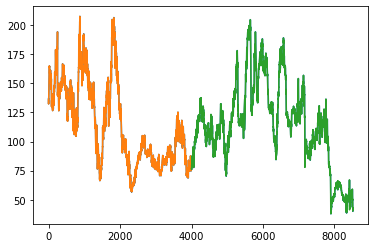

In [78]:
X_test = sm.add_constant(df_all[['minTemp', 'D_29', 'D_32', 'D_35', 'D_29 * minTemp', 'D_32 * minTemp', 'D_35 * minTemp', 'prev_day_2']])[4000:]
y_test = df_all['Settle_2'][4000:]

plt.plot(df_all['Settle_2'])
plt.plot(model22.fittedvalues)
plt.plot(model22.predict(X_test))

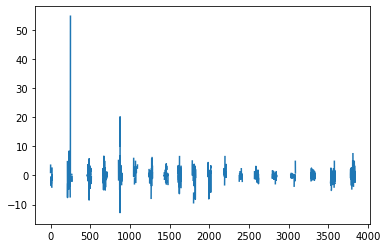

In [79]:
plt.plot(y-model22.fittedvalues)

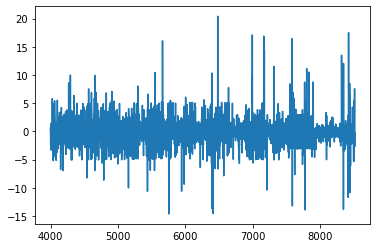

In [80]:
plt.plot(y_test-model22.predict(X_test))

In [85]:
print('r^2 value for actual and predicted: ',(np.corrcoef(y_test, model2.predict(X_test))[0,1])**2)

r^2 value for actual and predicted:  0.9962750381357047


In [86]:
df_all['prev_day_3'] = 0
counter = 0
for index, row in df_all.iterrows():
    try: 
        df_all.loc[index, 'prev_day_3'] = df_all.loc[index + 1, 'Settle_3']
    except: 
        df_all.loc[index, 'prev_day_3'] = df_all.loc[index, 'Settle_3']
        counter += 1
print(counter)

1


In [87]:
# IMPORTANT !!!!!!!!
# this is the model with all the dummy interactions and one previous day for Settle_3
# all seasons


model3 = sm.OLS(df_all['Settle_3'], sm.add_constant(df_all[['minTemp', 'D_29', 'D_32', 'D_35', 'D_29 * minTemp', 'D_32 * minTemp', 'D_35 * minTemp', 'prev_day_3']])).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Settle_3   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 2.484e+05
Date:                Thu, 06 May 2021   Prob (F-statistic):               0.00
Time:                        17:47:12   Log-Likelihood:                -18941.
No. Observations:                8516   AIC:                         3.790e+04
Df Residuals:                    8507   BIC:                         3.796e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.5136      0.182      2.820      0.005       0.157       0.871
minTemp           -0.0037      0.003     -1.473      0.141      -0.009       0.001
D_29              17.7670      6.776      2.622      0.009       4.485      31.049
D_32             -29.5659     13.146     -2.249      0.025     -55.335      -3.797
D_35              19.7556     11.675      1.692      0.091      -3.131      42.642
D_29 * minTemp    -0.6543      0.255     -2.570      0.010      -1.153      -0.155
D_32 * minTemp     0.9663      0.427      2.261      0.024       0.129       1.804
D_35 * minTemp    -0.5978      0.346     -1.726      0.084      -1.277       0.081
prev_day_3         0.9977      0.001   1408.474      0.000       0.996       0.999
==============================================================================
Omnibus:                     4686.865   Durbin-Watson:                   1.865
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           611503.392
Skew:                           1.647   Prob(JB):                         0.00
Kurtosis:                      44.382   Cond. No.                     7.28e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.28e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [88]:
df_all['prev_day_4'] = 0
counter = 0
for index, row in df_all.iterrows():
    try: 
        df_all.loc[index, 'prev_day_4'] = df_all.loc[index + 1, 'Settle_4']
    except: 
        df_all.loc[index, 'prev_day_4'] = df_all.loc[index, 'Settle_4']
        counter += 1
print(counter)

1


In [89]:
# IMPORTANT !!!!!!!!
# this is the model with all the dummy interactions and one previous day for Settle_4
# all seasons


model4 = sm.OLS(df_all['Settle_4'], sm.add_constant(df_all[['minTemp', 'D_29', 'D_32', 'D_35', 'D_29 * minTemp', 'D_32 * minTemp', 'D_35 * minTemp', 'prev_day_4']])).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Settle_4   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                 2.542e+05
Date:                Thu, 06 May 2021   Prob (F-statistic):               0.00
Time:                        17:47:18   Log-Likelihood:                -18641.
No. Observations:                8516   AIC:                         3.730e+04
Df Residuals:                    8507   BIC:                         3.736e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3775      0.177      2.135      0.033       0.031       0.724
minTemp           -0.0016      0.002     -0.666      0.505      -0.006       0.003
D_29              17.4835      6.541      2.673      0.008       4.661      30.306
D_32             -31.1042     12.691     -2.451      0.014     -55.981      -6.227
D_35              16.9401     11.271      1.503      0.133      -5.154      39.034
D_29 * minTemp    -0.6415      0.246     -2.610      0.009      -1.123      -0.160
D_32 * minTemp     1.0179      0.413      2.467      0.014       0.209       1.827
D_35 * minTemp    -0.5126      0.334     -1.533      0.125      -1.168       0.143
prev_day_4         0.9977      0.001   1424.760      0.000       0.996       0.999
==============================================================================
Omnibus:                     4447.424   Durbin-Watson:                   1.895
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           584048.541
Skew:                           1.500   Prob(JB):                         0.00
Kurtosis:                      43.460   Cond. No.                     7.29e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.29e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""